In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")

In [14]:
raw_df = pd.read_csv('UoW_load.csv', index_col='Dates ',parse_dates=True)
raw_df.head()

,9:00,10:00,11:00
Dates,,,
2018-01-01,89.4,90.6,88.6
2018-01-02,108.2,104.6,106.0
2018-01-03,110.0,111.6,114.8
2018-01-04,106.4,104.4,109.0
2018-01-05,97.8,100.4,102.4


In [15]:
# only consider the 11th hour column
leven_hour_df = raw_df.drop(['9:00', '10:00'], axis=1)
leven_hour_df.head()

,11:00
Dates,
2018-01-01,88.6
2018-01-02,106.0
2018-01-03,114.8
2018-01-04,109.0
2018-01-05,102.4


<AxesSubplot:xlabel='Dates '>

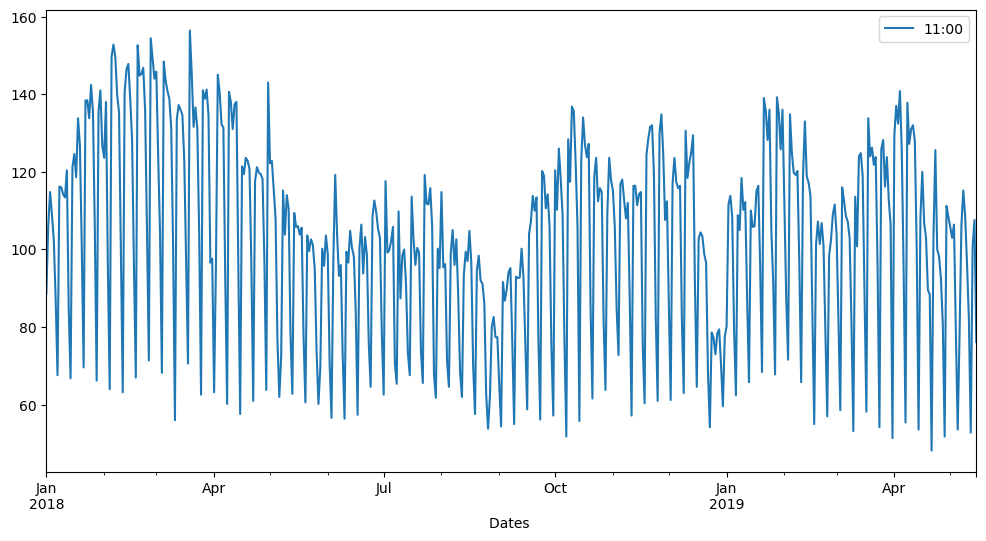

In [16]:
leven_hour_df.plot(figsize=(12,6))

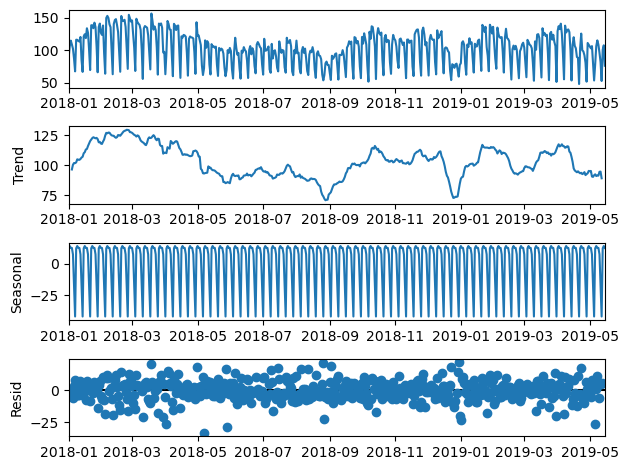

In [17]:
# check for trend, seasonality, and noise
results = seasonal_decompose(leven_hour_df)
results.plot();

In [18]:
len(leven_hour_df)

500

In [19]:
train = leven_hour_df.iloc[:430]
test = leven_hour_df.iloc[430:]

In [20]:
# define the scaler
scaler = MinMaxScaler()

In [21]:
# the train set beffore any scaling
before_scalling_tarin = pd.DataFrame(train)
before_scalling_tarin.describe()

,11:00
count,430.000000
mean,102.941395
std,25.267728
min,51.800000
25%,84.600000
50%,105.000000
75%,120.200000
max,156.400000


In [22]:
# scaling process of train set and test set
scaler.fit(train)
scaled_train = scaler.transform(train)
#scaled_test = scaler.transform(test)

In [26]:
# the train set after the scaling
after_scalling_tarin = pd.DataFrame(scaled_train)
after_scalling_tarin.describe()

,0
count,430.000000
mean,0.488923
std,0.241565
min,0.000000
25%,0.313576
50%,0.508604
75%,0.653920
max,1.000000


In [27]:
scaled_train[:10]

array([[0.35181644],
       [0.51816444],
       [0.60229446],
       [0.54684512],
       [0.48374761],
       [0.33843212],
       [0.15105163],
       [0.61567878],
       [0.61376673],
       [0.59655832]])

### Model with two hidden layers with 12 inputs 

In [33]:
# take 12 record of hourly load to predit 1 future hourly load
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [35]:
import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [36]:
# define model
model_1 = Sequential()
model_1.add(LSTM(64, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model_1.add(LSTM(32, activation='relu', return_sequences=False))
model_1.add(Dense(1))

model_1.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


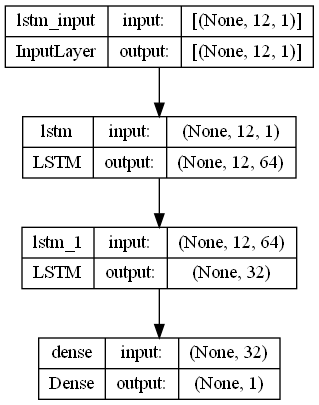

In [37]:
# Plot the model structure
plot_model(model_1, to_file='model_1.png', show_shapes=True)

In [38]:
len(model_1.layers)

3

In [39]:
# weights of each neurons for each layer 
def show_no_of_weigths(model):
    total_weigths = 0
    
    for i in range(len(model.layers)):
        
        weigths_per_layer = model.layers[i].get_weights()[0].size
        
        total_weigths += weigths_per_layer
        
        print('Layer ', i, ' weights :',  weigths_per_layer)
        
    print('Total No of Weigths Per Network :', total_weigths)

In [40]:
show_no_of_weigths(model_1)

Layer  0  weights : 256
Layer  1  weights : 8192
Layer  2  weights : 32
Total No of Weigths Per Network : 8480


In [31]:
# fit model
time_callback_1 = TimeHistory()
model_1.fit(generator, epochs=10, callbacks=[time_callback_1])

Epoch 1/10
418/418 [==============================] - 4s 10ms/step - loss: 0.0069 - mean_absolute_error: 0.0616
Epoch 2/10
418/418 [==============================] - 4s 11ms/step - loss: 0.0074 - mean_absolute_error: 0.0650
Epoch 3/10
418/418 [==============================] - 5s 11ms/step - loss: 0.0069 - mean_absolute_error: 0.0624
Epoch 4/10
418/418 [==============================] - 4s 10ms/step - loss: 0.0072 - mean_absolute_error: 0.0630
Epoch 5/10
418/418 [==============================] - 4s 10ms/step - loss: 0.0068 - mean_absolute_error: 0.0627
Epoch 6/10
418/418 [==============================] - 4s 10ms/step - loss: 0.0071 - mean_absolute_error: 0.0619
Epoch 7/10
418/418 [==============================] - 4s 10ms/step - loss: 0.0073 - mean_absolute_error: 0.0637
Epoch 8/10
418/418 [==============================] - 4s 11ms/step - loss: 0.0074 - mean_absolute_error: 0.0653
Epoch 9/10
418/418 [==============================] - 4s 11ms/step - loss: 0.0069 - mean_absolute_error:

In [29]:
print(sum(time_callback_1.times))

69.3164975643158


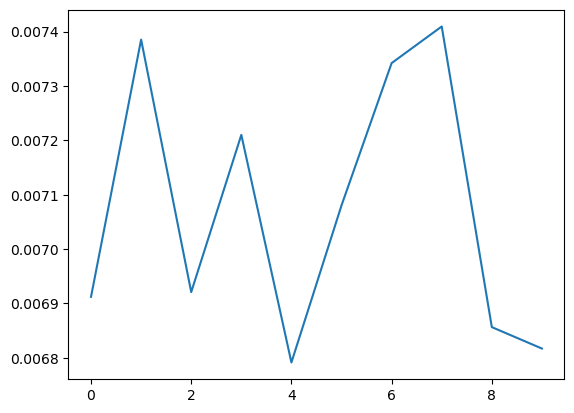

In [32]:
loss_per_epoch = model_1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [28]:
len(test)

70

In [33]:
def predict(n_input, n_features, train_set, test_set_size, model):
    test_predictions = []

    first_eval_batch = train_set[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(test_set_size):

        # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]

        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
        
    return test_predictions

In [34]:
test_predictions_1 = predict(n_input, n_features, scaled_train, len(test), model_1)

1/1 [==============================] - 0s 28ms/step


In [28]:
test.head()

,11:00
Dates,
2019-03-07,107.2
2019-03-08,103.0
2019-03-09,81.0
2019-03-10,53.2
2019-03-11,113.6


In [49]:
def plot_predictions(predictions, scaler, test_set, plot_title):

    true_predictions = scaler.inverse_transform(predictions)
    test_set['Predictions'] = true_predictions
    
    test_set.plot(figsize=(14,5), title=plot_title)

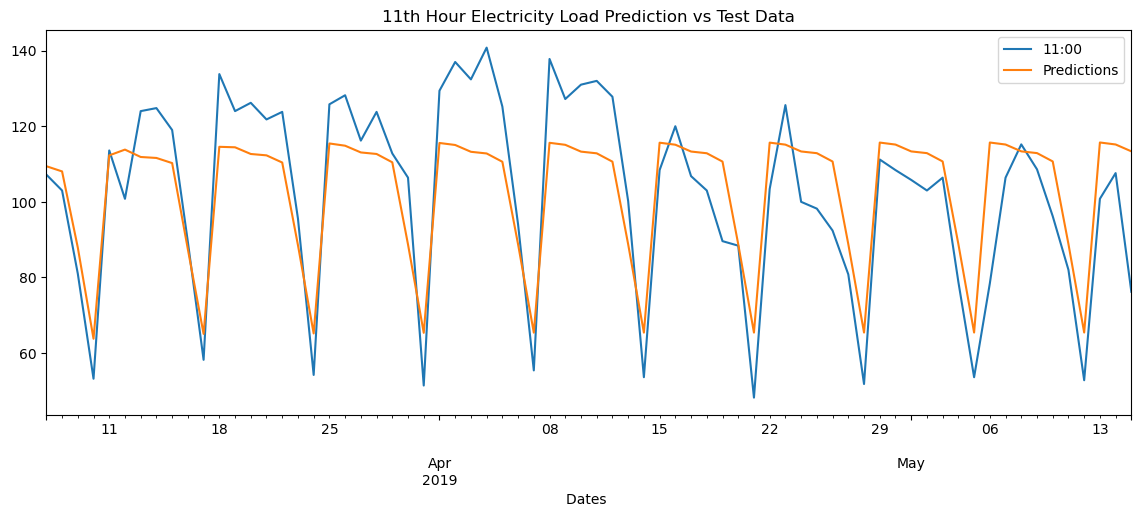

In [50]:
test_set = test.copy()
plot_predictions(test_predictions_1, scaler, test_set, '11th Hour Electricity Load Prediction vs Test Data')

In [53]:
def check_performances_indices(test_data, pred_data):
    rmse=sqrt(mean_squared_error(test_data, pred_data))
    print('RMSE:', rmse)
    
    mae = mean_absolute_error(test_data, pred_data)
    print('MAE:', mae)
    
    abs_pct_error = np.abs((test_data - pred_data) / test_data)
    mape = np.mean(abs_pct_error) * 100
    print('MAPE:', mape)

In [54]:
check_performances_indices(test['11:00'], test['Predictions'])

RMSE: 13.686766490584496
MAE: 11.71307652918356
MAPE: 12.554355914552287


### Model with 1 hidden layers with 12 inputs

In [41]:
# define model
model_2 = Sequential()
model_2.add(LSTM(64, activation='relu', input_shape=(n_input, n_features)))
model_2.add(Dense(1))

model_2.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


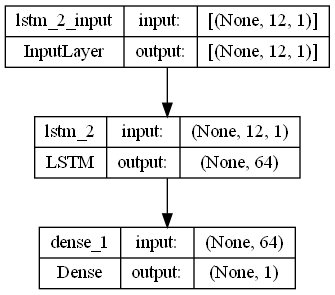

In [42]:
# Plot the model structure
plot_model(model_2, to_file='model_2.png', show_shapes=True)

In [43]:
show_no_of_weigths(model_2)

Layer  0  weights : 256
Layer  1  weights : 64
Total No of Weigths Per Network : 320


In [77]:
# fit model
time_callback_2 = TimeHistory()
model_2.fit(generator, epochs=10, callbacks=[time_callback_2])

Epoch 1/10
418/418 [==============================] - 4s 6ms/step - loss: 0.0579 - mean_absolute_error: 0.1994
Epoch 2/10
418/418 [==============================] - 3s 6ms/step - loss: 0.0534 - mean_absolute_error: 0.1923
Epoch 3/10
418/418 [==============================] - 2s 6ms/step - loss: 0.0535 - mean_absolute_error: 0.1918
Epoch 4/10
418/418 [==============================] - 2s 6ms/step - loss: 0.0501 - mean_absolute_error: 0.1844
Epoch 5/10
418/418 [==============================] - 3s 6ms/step - loss: 0.0388 - mean_absolute_error: 0.1549
Epoch 6/10
418/418 [==============================] - 3s 6ms/step - loss: 0.0275 - mean_absolute_error: 0.1324
Epoch 7/10
418/418 [==============================] - 3s 6ms/step - loss: 0.0232 - mean_absolute_error: 0.1214
Epoch 8/10
418/418 [==============================] - 3s 6ms/step - loss: 0.0202 - mean_absolute_error: 0.1141
Epoch 9/10
418/418 [==============================] - 3s 6ms/step - loss: 0.0171 - mean_absolute_error: 0.1017
E

In [52]:
print(sum(time_callback_2.times))

53.55385708808899


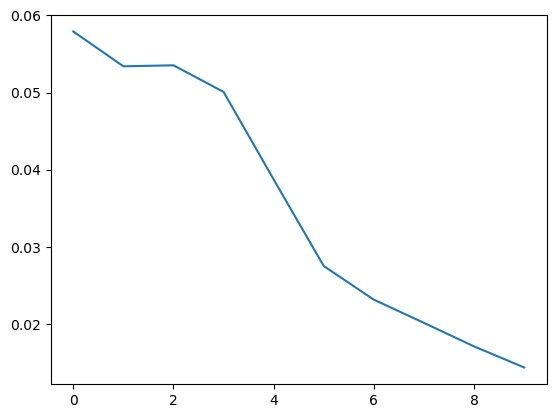

In [78]:
loss_per_epoch_2 = model_2.history.history['loss']
plt.plot(range(len(loss_per_epoch_2)), loss_per_epoch_2)

In [79]:
test_predictions_2 = predict(n_input, n_features, scaled_train, len(test), model_2)

1/1 [==============================] - 0s 31ms/step


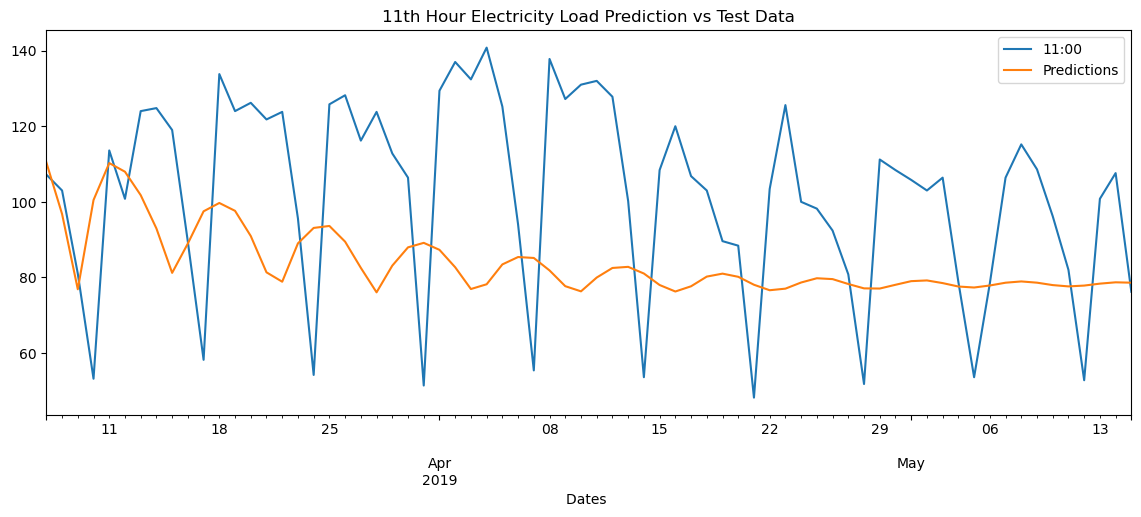

In [80]:
test_set_2 = test.copy()
plot_predictions(test_predictions_2, scaler, test_set_2, '11th Hour Electricity Load Prediction vs Test Data')

In [82]:
check_performances_indices(test_set_2['11:00'], test_set_2['Predictions'])

RMSE: 32.18346730259714
MAE: 27.958322160371722
MAPE: 28.475862785802242


### Model with 2 hidden layers with 24 inputs

In [44]:
# take 12 record of hourly load to predit 1 future hourly load
n_input = 24
n_features = 1
generator_2 = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [45]:
# define model
model_3 = Sequential()
model_3.add(LSTM(64, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model_3.add(LSTM(32, activation='relu', return_sequences=False))
model_3.add(Dense(1))

model_3.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 64)            16896     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


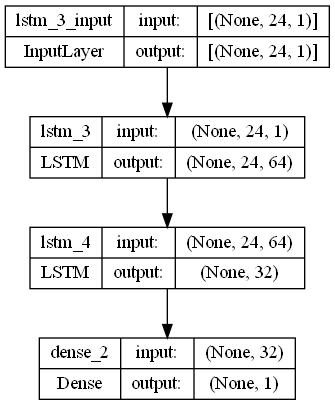

In [46]:
# Plot the model structure
plot_model(model_3, to_file='model_3.png', show_shapes=True)

In [47]:
show_no_of_weigths(model_3)

Layer  0  weights : 256
Layer  1  weights : 8192
Layer  2  weights : 32
Total No of Weigths Per Network : 8480


In [88]:
# fit model
time_callback_2 = TimeHistory()
model_3.fit(generator_2, epochs=10, callbacks=[time_callback_2])

Epoch 1/10
406/406 [==============================] - 10s 17ms/step - loss: 0.0580 - mean_absolute_error: 0.1968
Epoch 2/10
406/406 [==============================] - 7s 17ms/step - loss: 0.0523 - mean_absolute_error: 0.1861
Epoch 3/10
406/406 [==============================] - 7s 17ms/step - loss: 0.0480 - mean_absolute_error: 0.1789
Epoch 4/10
406/406 [==============================] - 7s 17ms/step - loss: 0.0325 - mean_absolute_error: 0.1429
Epoch 5/10
406/406 [==============================] - 7s 17ms/step - loss: 0.0209 - mean_absolute_error: 0.1175
Epoch 6/10
406/406 [==============================] - 7s 17ms/step - loss: 0.0178 - mean_absolute_error: 0.1058
Epoch 7/10
406/406 [==============================] - 7s 17ms/step - loss: 0.0186 - mean_absolute_error: 0.1047
Epoch 8/10
406/406 [==============================] - 7s 17ms/step - loss: 0.0160 - mean_absolute_error: 0.1000
Epoch 9/10
406/406 [==============================] - 6s 15ms/step - loss: 0.0149 - mean_absolute_error

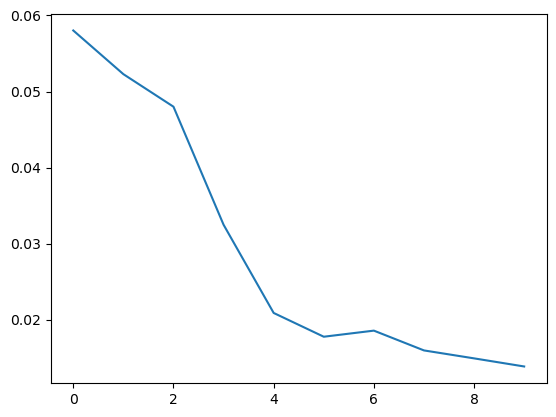

In [89]:
loss_per_epoch_3 = model_3.history.history['loss']
plt.plot(range(len(loss_per_epoch_3)), loss_per_epoch_3)

In [90]:
test_predictions_3 = predict(n_input, n_features, scaled_train, len(test), model_3)

1/1 [==============================] - 0s 31ms/step


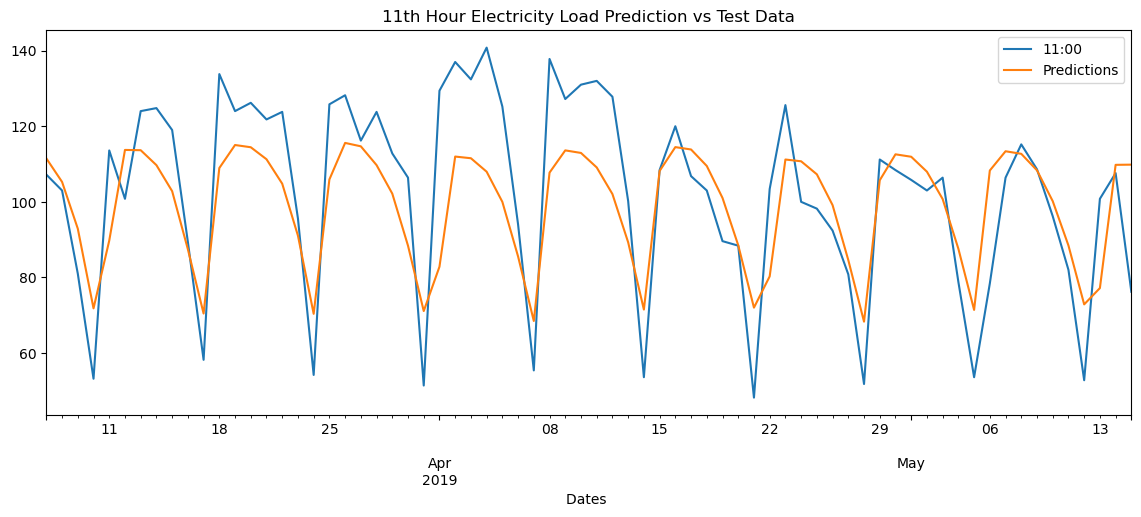

In [91]:
test_set_3 = test.copy()
plot_predictions(test_predictions_3, scaler, test_set_3, '11th Hour Electricity Load Prediction vs Test Data')

In [92]:
check_performances_indices(test_set_3['11:00'], test_set_3['Predictions'])

RMSE: 16.530209560860307
MAE: 13.638789444438048
MAPE: 14.731739002090919
